# Detecting Changes in Sentinel-1 Imagery
## Part 1. Single and multi-look image statistics

Author: mortcanty

Issue #210

In this tutorial we will analyze Sentinel-1 imagery archived on the GEE in order to detect statistically significant changes over time. As the adverb "statistically" hints, we will need a basic understanding of the statistical properties of SAR imagery in order to proceed, and the adjective "significant" implies that we  learn the fundamentals of hypothesis testing. In particular we will be concerned with the dual polarimetric intensity images in the GEE archive. The tutorial is in three parts:

- 1. Single and multi-look image statistics
- 2. Hypothesis testing for change detection
- 3. Applications

## Context

The Sentinel-1 missions of the ESA provide a fantastic source of weather-independent Earth observation data with repeat times of the order of 6 days. The Google Earth Engine team monitor and ingest the imagery data virtually as fast as they are produced, thus removing the burden from the user of searching, pre-processing and georeferencing. The JavaScript and Python API's to the GEE can then be easily programmed to analyze time series of Sentinel-1 acquisitions virtually anywhere on the globe. Detected changes, both short- and long-term can be related to landscape dynamics and human activity.

### Datasets
Two datasets will be used in the tutorial:
- COPERNICUS/S1_GRD_FLOAT
  - Sentinel-1 ground range detected images
- COPERNICUS/S1_GRD  
  - Sentinel-1 ground range detected images converted to decibels

First we import the GEE Python API, authenticate ourselves and initialize:

In [7]:
import ee
#ee.Authenticate()
ee.Initialize()

Next import a few Python modules and enable inline plotting.

In [21]:
import matplotlib.pyplot as plt
import numpy as np
from scipy.stats import gamma
import IPython.display as disp
from ipyleaflet import Map,TileLayer
%matplotlib inline

Let's start work by grabbing a spatial subset of a Sentinel-1 image from the archive and examining it. 
We'll define a region of interest (roi) as the long-lat corners of a rectangle over the Frankfurt Airport. A convenient way to do this is from the website http://geojson.io/#map=2/20.0/0.0, from which we can cut and paste the corresponding geoJSON description.

In [9]:
geoJSON = {
  "type": "FeatureCollection",
  "features": [
    {
      "type": "Feature",
      "properties": {},
      "geometry": {
        "type": "Polygon",
        "coordinates": [
          [
            [
              8.473892211914062,
              49.98081240937428
            ],
            [
              8.658599853515625,
              49.98081240937428
            ],
            [
              8.658599853515625,
              50.06066538593667
            ],
            [
              8.473892211914062,
              50.06066538593667
            ],
            [
              8.473892211914062,
              49.98081240937428
            ]
          ]
        ]
      }
    }
  ]
}

Note that the last and first corners are identical, indicating closure of the polynomial. We have to bore down into the geoJSON structure to get the geometry coordinates and then create an _ee.Geometry()_ object:

In [11]:
coords = geoJSON['features'][0]['geometry']['coordinates']
roi = ee.Geometry.Polygon(coords)

Next, we filter the S1 archive to get an image over the roi acquired sometime in August, 2020. Any old image will do fine, so we won't bother to specify the orbit number or whether we want the ASCENDING or DESCENDING node. For convenience we grab both decibel and float versions:

In [12]:
ffa_db = ee.Image( ee.ImageCollection('COPERNICUS/S1_GRD') \
                       .filterBounds(roi) \
                       .filterDate(ee.Date('2020-08-01'),ee.Date('2020-08-31')) \
                       .first() \
                       .clip(roi))
ffa_fl = ee.Image( ee.ImageCollection('COPERNICUS/S1_GRD_FLOAT') \
                       .filterBounds(roi) \
                       .filterDate(ee.Date('2020-08-01'),ee.Date('2020-08-31')) \
                       .first() \
                       .clip(roi))

Notice that we have clipped the images to our roi, so as not to work with the entire swath. To confirm that we have an image, we list its bandnames, fetching the result from the GEE servers with the _getInfo()_ class method:

In [13]:
ffa_db.bandNames().getInfo()

['VV', 'VH', 'angle']

and display the VV band of the decibel version using the _getThumbURL()_ method and IPython's _display_ module. The float intensities $I$ are generally between 0 and 1, so we stretch the decibel image $10\log_{10}(I)$, from $-20$ to $0$:

In [14]:
url = ffa_db.select('VV').getThumbURL({'min':-20,'max':0})
disp.Image(url=url,width=800, height=800)

This is fine, but a little boring. Let's mimic some of the functionality of the GEE code editor, projecting the image onto a slippy map with _ipyleaflet_ :

In [15]:
def GetTileLayerUrl(ee_image_object):
    map_id = ee.Image(ee_image_object).getMapId()
    return map_id["tile_fetcher"].url_format

# The ipyleaflet Map() requires latlong coodinates so the list is reversed
center = roi.centroid().coordinates().getInfo()[::-1]
m = Map(center=center, zoom=12)
m.add_layer(
    TileLayer(url=GetTileLayerUrl(ffa_db.select('VV').visualize(min=-20, max=0)))
)
m

Map(center=[50.02076448259734, 8.566246032714204], controls=(ZoomControl(options=['position', 'zoom_in_text', …

### Pixel distributions

In order to examine the statistics of the pixels in this image empirically, we'll need pixels from a featureless (textureless) subset. Here is a polygon covering the triangular wooded area at the lower center:

In [16]:
geoJSON = {
  "type": "FeatureCollection",
  "features": [
    {
      "type": "Feature",
      "properties": {},
      "geometry": {
        "type": "Polygon",
        "coordinates": [
          [
            [
              8.534317016601562,
              50.021637833966786
            ],
            [
              8.530540466308594,
              49.99780882512238
            ],
            [
              8.564186096191406,
              50.00663576154257
            ],
            [
              8.578605651855469,
              50.019431940583104
            ],
            [
              8.534317016601562,
              50.021637833966786
            ]
          ]
        ]
      }
    }
  ]
}
coords = geoJSON['features'][0]['geometry']['coordinates']
roi_sub = ee.Geometry.Polygon(coords)

Using standard reducers from the GEE library we can easily calculate a histogram and estimate the first two moments (mean and variance) of the pixels in the polygon _roi1_ , again retrieving the results from the servers with _getInfo()_ .

In [17]:
hist = ffa_fl.select('VV').reduceRegion(ee.Reducer.fixedHistogram(0,0.5,500),roi_sub).get('VV').getInfo()
mean = ffa_fl.select('VV').reduceRegion(ee.Reducer.mean(),roi_sub).get('VV').getInfo()
variance = ffa_fl.select('VV').reduceRegion(ee.Reducer.variance(),roi_sub).get('VV').getInfo()

Here is a plot of the (normalized) histogram using _numpy_ and _matplotlib_ :

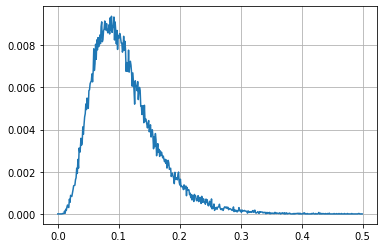

In [18]:
a = np.array(hist)
x = a[:,0]
y = a[:,1]/np.sum(a[:,1])
plt.grid()
plt.plot(x,y)
plt.show()

The above histogram is in fact a gamma probability density distribution 

$$
p_\gamma(x) = {1\over \beta^\alpha\Gamma(\alpha)}x^{\alpha-1}e^{-x/\beta} \tag{1.1}
$$


with parameters $\alpha = 5$ and $\beta = {\mu}/\alpha$, where $\mu$ is the estimated mean value we just determined with GEE. We can easily verify this by plotting the gamma function with these parameters and overlaying it onto the histogram:

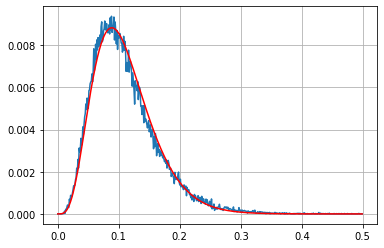

In [19]:
alpha = 5
beta = mean/alpha
plt.grid()
plt.plot(x,y)
plt.plot(x, gamma.pdf(x, alpha, 0, beta)/1000, '-r')
plt.show()

In order to undersand just why this is the case, we have to take a step back and consider how the pixels were generated.


### Single look complex (SLC) SAR statistics
The Sentinel-1 platform is a dual polarimteric SAR sensor system, emitting one polarization (vertical in most cases) and recording both vertical and horizontal reflected polarizations. This is represented mathematically as

$$
\pmatrix{E_v^b\cr E_h^b} = {e^{-{\bf i}rk}\over r}\pmatrix{S_{vv} & S_{vh}\cr S_{hv} & S_{hh}}\pmatrix{E_v^i\cr 0}. \tag{1.2}
$$

The incident vertically polarized radar signal $\pmatrix{E_v^i\cr 0}$ is transformed by a complex _scattereing matrix_ $\pmatrix{S_{vv} & S_{vh}\cr S_{hv} & S_{hh}}$ into the backscattered signal $\pmatrix{E_v^b\cr E_h^b}$ having both vertical and horizontal polarization components. The exponent accounts for the phase shift due to the return distance $r$ from target to sensor, with wave number $k=2\pi/\lambda$. From measurement of the backscattered radiation at the sensor, two of the four complex scattering matrix elements can be derived. Written as a  vector, they are:
 
$$
S = \pmatrix{S_{vv}\cr S_{vh}}.          \tag{1.3}
$$

We write the complex transpose of the vector $S$ as $S^\dagger = (S_{vv}^*\ S_{vh}^*)$, where the $*$ denotes complex conjugation. The inner product of $S$ with itself is the total received power (also referred to as the _span_ image)

$$
P2 = S^\dagger S = (S_{vv}^*\ S_{vh}^*)\pmatrix{S_{vv}\cr S_{vh}} = |S_{vv}|^2 + |S_{vh}|^2 \tag{1.4}
$$

and the outer product is the (dual pol) _covariance matrix image_

$$
C2 = SS^\dagger = \pmatrix{S_{vv}\cr S_{vh}}(S_{vv}^*\ S_{vh}^*) = \pmatrix{|S_{vv}|^2 & S_{vv}^*S_{vh} \cr S_{vh}^*S_{vv} & |S_{vh}|^2}. \tag{1.5}
$$

The diagonal elements are real numbers, the off-diagonal elements are complex conjugates of eachother and contain the relative phases of the $S_{vv}$ and $S_{vh}$ components. The off-diagonal elements are not available for S1 archived imagery on the GEE, so that if we nevertheless choose to represent the data in covariance matrix form, the matrix is diagonal: 

$$
C2 = \pmatrix{|S_{vv}|^2 & 0 \cr 0 & |S_{vh}|^2}. \tag{1.6}
$$

#### Speckle

The most striking characteristic of SAR images, when compared to their visual/infrared
counterparts, is the disconcerting _speckle_ effect which makes visual interpretation very
difficult. Speckle gives the appearance of random noise, but
it is actually a deterministic consequence of the coherent nature of the radar signal.

For single polarization transmission and reception, e.g., vertical-vertical ($vv$), the received SLC signal can be modelled in the form

$$
S_{vv} = {|S^a_{vv}|\over\sqrt{n}}\sum_{k=1}^n e^{{\bf i}\phi_k}, \tag{1.7}
$$

where $|S^a_{vv}|$ is the overall amplitude characterizing the signal scattered from the  area covered by a single pixel, e.g., $10\times 10\ m^2$ for our S1 data,  with the phase set equal to zero for convenience. The effects of randomly distributed scatterers within the irradiated area, with dimensions  of the order of the incident wavelength (for C-band approx. 8 cm), add coherently and introduce a change in phase of the  received signal as indicated in the above equation. This effect varies from pixel to pixel and gives rise to _speckle_ in the intensities $|S_{vv}|^2$ that we actually work with when we analyze a Sentinel-1 VV band. 

If we expand Eq. (1.7) into its real and imaginary parts, we can understand it better:

$$
S_{vv} = {|S^a_{vv}|\over\sqrt{n}}\sum_{k=1}^n e^{{\bf i}\phi_k} = {|S^a_{vv}|\over\sqrt{n}}\left(\sum_k\cos\phi_k + {\bf i}\sum_k\sin\phi_k\right) =  {|S^a_{vv}|\over\sqrt{n}}(x + {\bf i}y) \tag{1.8}
$$

Because the phase shifts $\phi_k$ are randomly and uniformly distributed, the variables $x$ and $y$ are sums of identically distributed cosine and sine terms respectively. The Central Limit Theorem of statistics then says that $x$ and $y$ will have a normal distribution with zero mean and variance $\sigma^2 =n/2$ in the limit of large $n$. We can verify this with a simple piece of code in which we set $n=10000$:

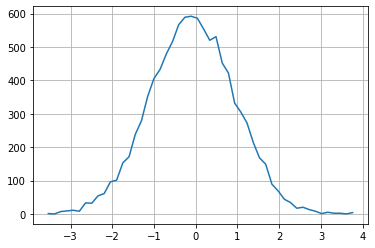

In [12]:
def X(n):
    return np.sum(np.cos(4*np.pi*(np.random.rand(n)-0.5)))/np.sqrt(n/2)

n= 10000
Xs = [X(n) for i in range(10000)]
y,x = np.histogram(Xs,50)
plt.plot(x[:-1],y)
plt.grid()
plt.show()

Furthermore, $x$ and $y$ are uncorrelated since, in the expression for covariance of $x$ and $y$, the sums of products of cosine and sine terms cancel to zero. This means that  $x + {\bf i}y$, and hence the observed single look complex signal $S_{vv}$, has a __complex normal distribution__ .

Now what about the pixels values in the Sentinel-1 VV intensity images? They are given by the square of the amplitude of $S_{vv}$,

$$
|S_{vv}|^2 = S_{vv}S^*_{vv} = {|S^a_{vv}|^2\over n}(x^2+y^2). \tag{1.9}
$$

We can write this in the form

$$
|S_{vv}|^2 =  {|S^a_{vv}|^2\over n}{n\over 2}\left({x^2\over n/2}+{y^2\over n/2}\right) = |S^a_{vv}|^2{u\over 2}, \tag{1.10}
$$

where 

$$
u = \left({x^2\over n/2}+{y^2\over n/2}\right) \tag{1.11}
$$

is the sum of the squares of two variables with independent standard normal distributions. Statistical theory then tells us that $u$ has a _chi-square distribution_ with two degrees of freedom, namely

$$
p_u(u) = {1\over 2}e^{-u/2}. \tag{1.12}
$$

To simplify the notation, let $s=|S_{vv}|^2 $ and  $a=|S^a_{vv}|^2$. Then from (1.10)

$$
s = a{u\over 2} \tag{1.13}
$$

To get the distribution $p_s(s)$ of the observed signal from the distribution of $u$, we apply the standard transformation formula

$$
p_s(s) = p_u(u)\left|{du\over ds}\right| = {1\over 2}e^{-u/2}{2\over a} = {1\over a} e^{-s/a}. \tag{1.14}
$$

Compare this with the exponential probability distribution, which is given by

$$
p_{exp}(z) = {1\over\beta}e^{-z/\beta} \tag{1.15}
$$

and which has mean and variance $\beta$. __We conclude that the measured intensity signal $s=|S_{vv}|^2$ has an exponential distribution with mean and variance equal to the underlying signal strength $a=|S^a_{vv}|^2$.__ 



### Multi-look SAR statistics

Multi-look processing essentially corresponds to the averaging of neighborhood pixels with the objective
of reducing speckle and compressing the data. In practice, the averaging is often not performed in the
spatial domain, but rather in the frequency domain during range/azimuth compression of the received signal. 

Look averaging takes place at the cost of spatial resolution. The spatial resolution attainable with SAR satellite platforms  involves, among many other considerations, a compromise between azimuthal resolution and swath width, see https://elib.dlr.de/82313/ for a good discussion. In the Sentinel-1 _Interferometric Wide Swath_ acquisition mode, the pixels are about 20m $\times$ 4m (azimuth $\times$ range) in extent and the swath widths are about 250km. In the multi-looking procedure, five cells are incoherently averaged in the range direction to achieve $20m \times 20m$ resolution. (Pixels ingested into the GEE are resampled to $10m\times 10m$.) The averaging process, which we can symbolize using angular brackets as $\langle |S_{vv}|^2 \rangle$ or $\langle |S_{vh}|^2 \rangle$, has the desirable effect of reducing speckle (at the cost of range resolution) in the intensity images. We can see this as follows, first quoting a well-known Theorem in statistics:

   - If the quantities $s_i,\ i=1\dots m,$ are independent and each have exponential distributions given by Eq. (1.14), then $x = \sum_{i=1}^m s_i$ has the gamma distribution Eq. (1.1) with $\alpha=m,\ \beta=a$. Its mean is $\alpha\beta =ma$ and its variance is $\alpha\beta^2 = ma^2.$

Again with the notation $s=|S_{vv}|^2 $ and  $a=|S^a_{vv}|^2$, if intensity measurements $s$ are summed over $m$ looks to give $\sum_{i=1}^m s_i$, then according to this Theorem  the sum (not the average!) will be gamma distributed with $\alpha= m$ and $\beta=a$, provided the $s_i$ are independent. The look-averaged image is

$$
\langle s\rangle = {1\over m}\sum_{i=1}^m s_i \tag{1.16}
$$

and its mean value is

$$
{\rm mean}(\langle s\rangle) = {1\over m}\sum_{i=1}^m {\rm mean}(s_i) = {1\over m}\sum_{i=1}^m a = a. \tag{1.17}
$$

Now we see that the histogram of the Sentinel-1 multi-look image $\langle s\rangle =\langle |S_{vv}|^2 \rangle$ that we generated above must follow a gamma distribution with the parameters 

$$
\alpha=m,\quad \beta' = {a\over m} = {{\rm mean}(\langle s\rangle)\over m}, \tag{1..18}
$$

as we demonstrated.

The variance of $\langle s\rangle$ is given by

$$
{\rm var}(\langle s\rangle) = {1\over m^2}{\rm var}(\sum_{i=1}^m s_i)= {1\over m^2}ma^2 = {a^2\over m}. \tag{1.19}
$$

where we have used the fact that the variance of the gamma distribution is $\alpha\beta'^2=ma^2$.

In practice, the neighborhood pixel intensities contributing to the look average will not be completely independent, but correlated to some extent. This is accounted for by defining an _equivalent number of looks_
(ENL) whose definition is motivated by Eq. (1.19), that is,

$$
{\rm ENL} = {a^2\over {\rm var}(\langle s\rangle)} = {{\rm mean}(\langle s\rangle)^2\over {\rm var}(\langle s\rangle)}.\tag{1.20}
$$

In general it will be smaller than $m$. Let's see what we get for our airport image:

In [20]:
mean**2/variance

4.324058395540761

The value given by the provider (ESA) for the COPERNICUS/S1_GRD_FLOAT imagery in the GEE archive is ENL = 4.4.

In Part 2 of the Tutorial we will discuss statistical methods to detect changes in two or more S1 images.